In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Author: Drew Rebar<br>
The purpose of this notebook is to analyze the frequency content of quantum oscillation data from pulse field<br>
experiments at the National High Magnetic Field Laboratory located at Los Alamos National Laboratory, Los Alamos, NM.

<a id="Outline"></a>

# Outline
<ul>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

<a id="Importing-Packages"></a>

## Importing Packages

In [2]:
#The following subsection clears the deprecation warnings for matplotlib. If the plots begin malfunctioning, comment out this subsection 
#in order to view the warnings.
#######################################
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#######################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy import fft
import scipy.signal as signal

<a id="Import-Data"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
</ul>

## Import Data
<ul>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

In [3]:
#read data file
data_file = "sample.ASC"
df = pd.read_csv(data_file, delimiter='\t')

#check for null values
print("Null values in data:",df.isnull().values.any())

#look at data sample
df.head()

Null values in data: False


,Bdot,Idot,Mag1,Mag2,Field,Field_fixed
0,-0.009766,-0.012207,-0.092865,0.011815,0.000010,0.000010
1,-0.009155,-0.010986,-0.058423,0.003289,0.000008,0.000006
2,-0.007935,-0.010376,-0.041201,-0.010351,-0.000007,-0.000011
3,-0.008850,-0.011292,-0.015370,0.003289,-0.000016,-0.000022
4,-0.008545,-0.012207,-0.092865,-0.018876,-0.000027,-0.000035


<a id="Define-Data-Set-for-Analysis"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
</ul>

## Define Data Set for Analysis
<ul>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

<IPython.core.display.Javascript object>


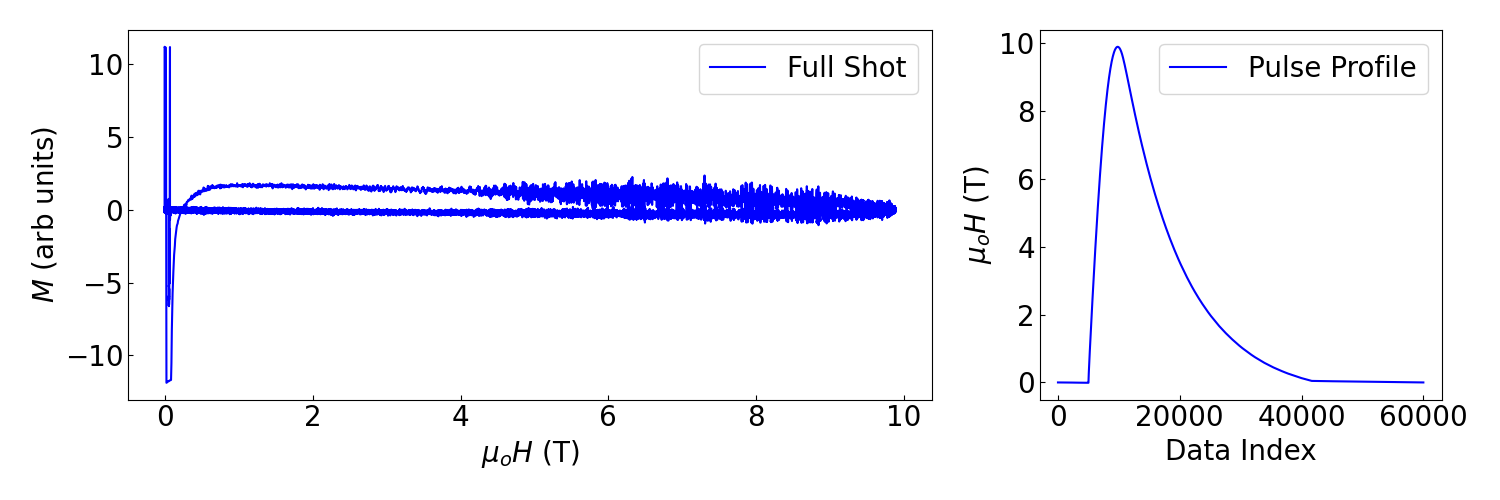

In [4]:
##Important! Define data sets and labels. Use exact column label.
################################################################
Y_column_name = 'Mag1'
X_column_name = 'Field_fixed'
################################################################

dat = pd.DataFrame()
dat['Y'] = df[Y_column_name]
dat['X'] = df[X_column_name]

#graph labels
labelY = '$M$ (arb units)'
labelX = '$\\mu_o H$ (T)'
labelXinv = '1/$\\mu_o H$ (T$^{-1}$)'

#saved data plot tag, plot pic type set as .png
tag = 'sample_'
pic = '.png'

#Plot raw data
%matplotlib notebook
plt.rcParams.update({'font.size': 20})
fig1= plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2, width_ratios=[1, 0.5])

ax1 = plt.subplot(gs[0], xlabel=labelX, ylabel=labelY)
ax1.plot(dat.X, dat.Y, 'b', label='Full Shot', )
ax1.legend(loc='upper right')
ax1.tick_params(direction='in')

ax2 = plt.subplot(gs[1], xlabel='Data Index', ylabel=labelX)
ax2.plot(dat.X, 'b', label='Pulse Profile')
ax2.legend(loc='upper right')
ax2.tick_params(direction='in')

plt.tight_layout()
plt.savefig(tag + 'dat_all' + pic, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Edit-and-Split-Data-Set"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
</ul>  

## Edit and Split Data Set
<ul>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

<IPython.core.display.Javascript object>


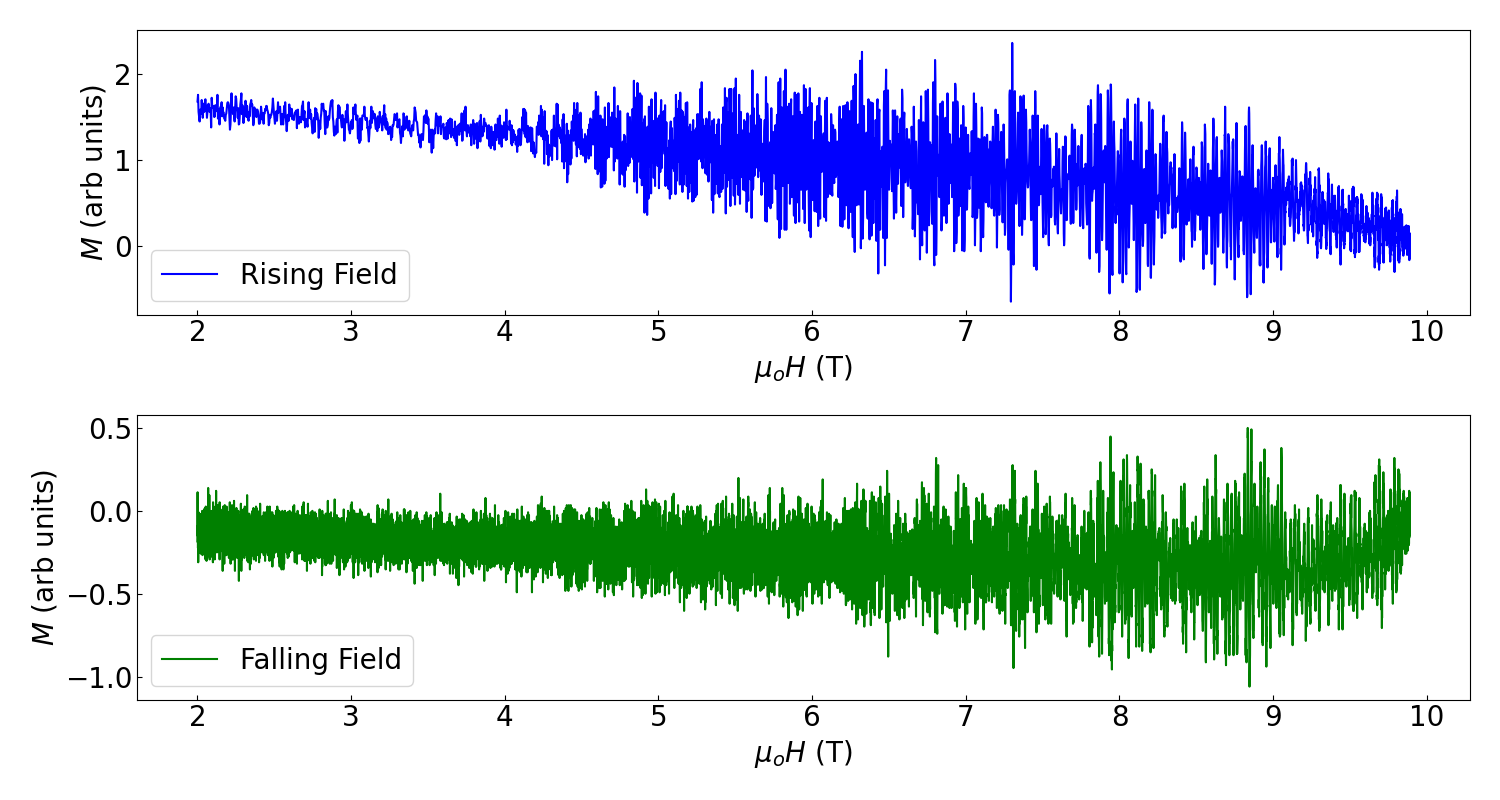

In [5]:
#chop noisy low field data
dat = dat[dat.X > 2]
dat.reset_index(inplace=True, drop=True)

#split data into rising and falling pulse field data sets
index = dat.X.idxmax()

dat_rising = dat.iloc[:index+1]
dat_falling = dat.iloc[index+1:]


#plot split data
plt.rcParams.update({'font.size': 20})
fig1, (ax1,ax2) = plt.subplots(2, figsize=(15,8))
ax1.plot(dat_rising.X, dat_rising.Y, 'b', label='Rising Field')
ax1.set(xlabel=labelX, ylabel=labelY)
ax1.tick_params(direction='in')
ax1.legend(loc='lower left')

ax2.plot(dat_falling.X, dat_falling.Y, 'g', label='Falling Field')
ax2.set(xlabel=labelX, ylabel=labelY)
ax2.tick_params(direction='in')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.savefig(tag + 'dat_split' + pic, dpi=300, bbox_inches = "tight")
plt.show()


<a id="Background Subtraction"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
</ul> 

## Background Subtraction
<ul>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

<IPython.core.display.Javascript object>


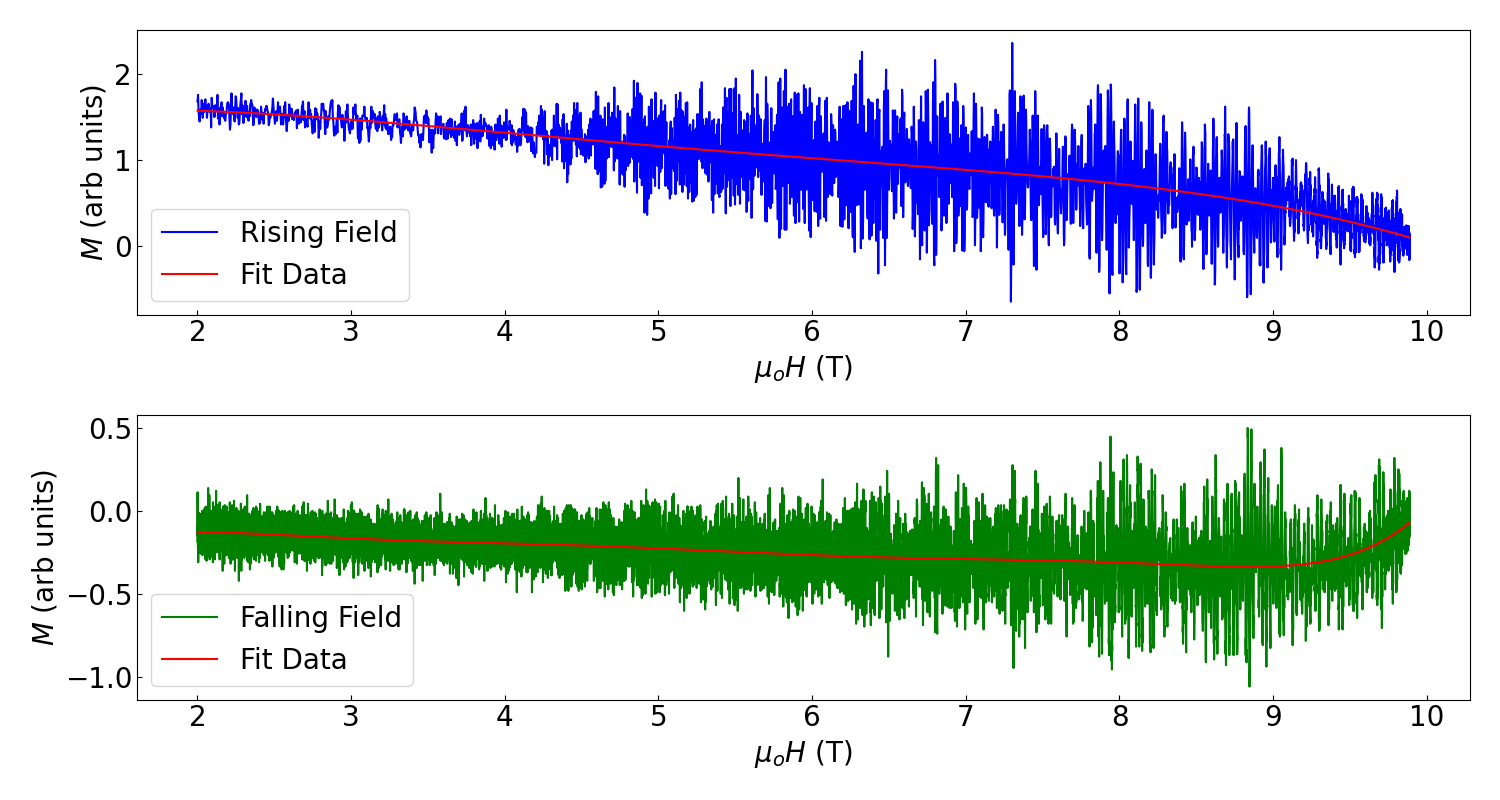

In [6]:
##Data fit for background subtraction

#to modify data fit process, perform the following:
# 1.add or remove terms in the polynomial functions
# 2.add or remove zeroes in p0
# 3.add or remove terms in the fit functions

def polynomial_1(x, a, b, c, d, f):
    return a*x**0 + b*x**1 + c*x**2 + d*x**3 + f*x**4# + g*x**5 + h*x**6 + k*x**7

def polynomial_2(x, a, b, c, d, f, g, h, k):
    return a*x**0 + b*x**1 + c*x**2 + d*x**3 + f*x**4 + g*x**5 + h*x**6 + k*x**7

#data fit for rising field
pars1, cov1 = curve_fit(f=polynomial_1, xdata=dat_rising.X, ydata=dat_rising.Y, p0=[0,0,0,0,0], bounds=(-np.inf, np.inf))

fit_rising = pars1[0]*dat_rising.X**0 + pars1[1]*dat_rising.X**1 + pars1[2]*dat_rising.X**2 + pars1[3]*dat_rising.X**3 + pars1[4]*dat_rising.X**4 \
#                   + pars1[5]*dat_rising.X**5 + pars1[6]*dat_rising.X**6 + pars1[7]*dat_rising.X**7

#data fit for falling field
pars2, cov2 = curve_fit(f=polynomial_2, xdata=dat_falling.X, ydata=dat_falling.Y, p0=[0,0,0,0,0,0,0,0], bounds=(-np.inf, np.inf))

fit_falling = pars2[0]*dat_falling.X**0 + pars2[1]*dat_falling.X**1 + pars2[2]*dat_falling.X**2 + pars2[3]*dat_falling.X**3 + pars2[4]*dat_falling.X**4 \
                + pars2[5]*dat_falling.X**5 + pars2[6]*dat_falling.X**6 + pars2[7]*dat_falling.X**7

#plot pulse field fitting
plt.rcParams.update({'font.size': 20})
fig1, (ax1,ax2) = plt.subplots(2, figsize=(15,8))
ax1.plot(dat_rising.X, dat_rising.Y, 'b', label='Rising Field')
ax1.plot(dat_rising.X, fit_rising, 'r', label='Fit Data')
ax1.set(xlabel=labelX, ylabel=labelY)
ax1.tick_params(direction='in')
ax1.legend(loc='lower left')

ax2.plot(dat_falling.X, dat_falling.Y, 'g', label='Falling Field')
ax2.plot(dat_falling.X, fit_falling, 'r', label='Fit Data')
ax2.set(xlabel=labelX, ylabel=labelY)
ax2.tick_params(direction='in')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.savefig(tag + 'dat_background_fit' + pic, dpi=300, bbox_inches = "tight")
plt.show()


<IPython.core.display.Javascript object>


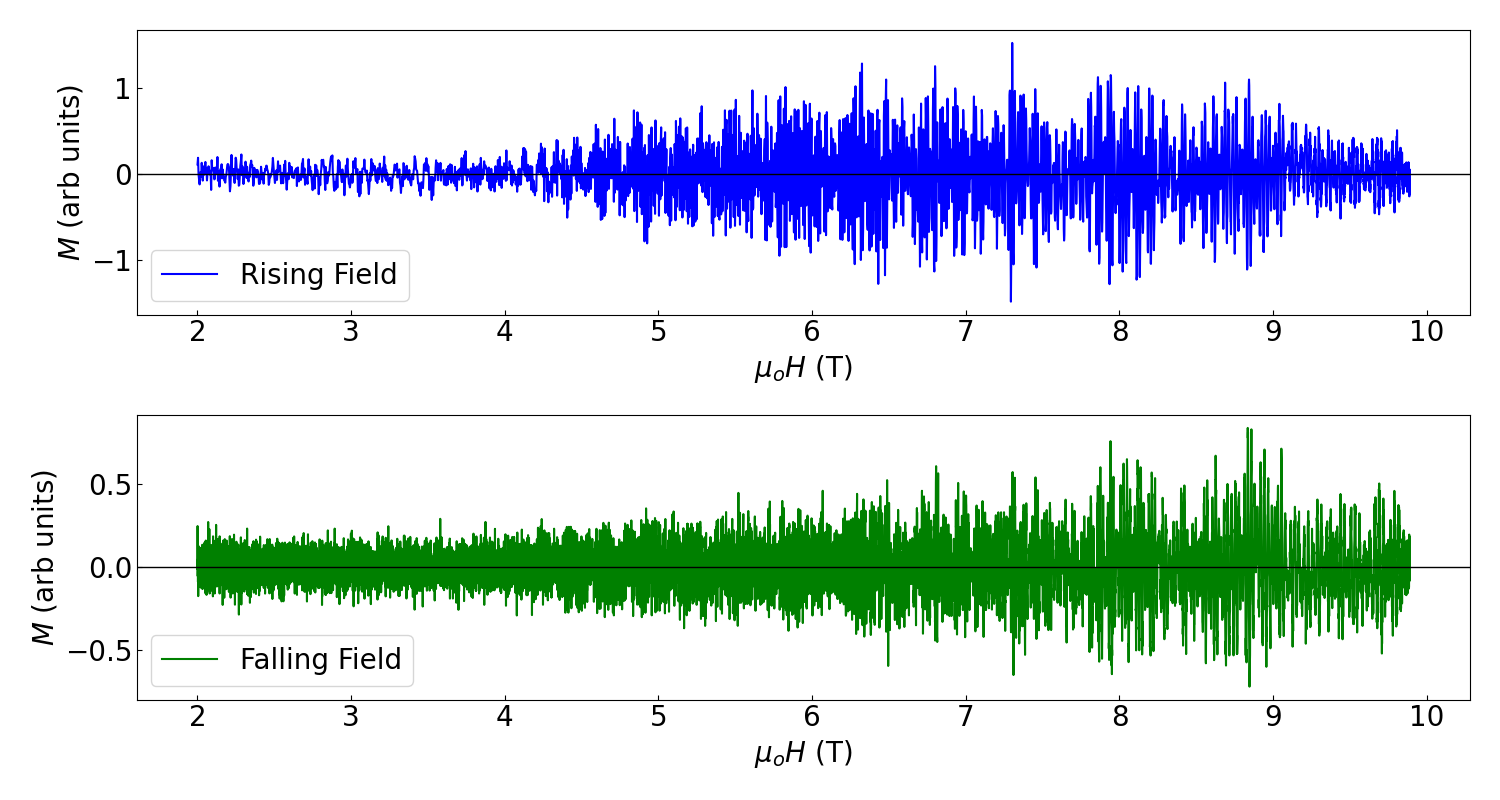

In [7]:
#subtracting the background fit
dat_rising['norm'] = dat_rising.Y - fit_rising
dat_falling['norm'] = dat_falling.Y - fit_falling

#plot normalized data
plt.rcParams.update({'font.size': 20})
fig1, (ax1,ax2) = plt.subplots(2, figsize=(15,8))

ax1.plot(dat_rising.X, dat_rising.norm, 'b', label='Rising Field')
ax1.set(xlabel=labelX, ylabel=labelY)
ax1.tick_params(direction='in')
ax1.legend(loc='lower left')
ax1.axhline(linewidth=1, color='k')

ax2.plot(dat_falling.X, dat_falling.norm, 'g', label='Falling Field')
ax2.set(xlabel=labelX, ylabel=labelY)
ax2.tick_params(direction='in')
ax2.legend(loc='lower left')
ax2.axhline(linewidth=1, color='k')

plt.tight_layout()
plt.savefig(tag + 'norm_dat' + pic, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Data-Preparation-for-FFT"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
</ul>

## Data Preparation for FFT
<ul>
<li><a href="#FFT-Calculation-and-Plotting">FFT Calculation and Plotting</a></li>
</ul>

In [8]:
#Invert field axis
dat_rising['invX'] = 1 / dat_rising.X
dat_falling['invX'] = 1 / dat_falling.X

#Drop duplicate values if any
dat_rising.drop_duplicates(subset='invX', keep='first', inplace=True)
dat_falling.drop_duplicates(subset='invX', keep='first', inplace=True)

#Reorder rising and falling pulse data sets to be ascending in inverse field
dat_rising.sort_values('invX', axis=0, ascending=True, inplace=True)
dat_falling.sort_values('invX', axis=0, ascending=True, inplace=True)

#Reindex rising and falling pulse data sets
dat_rising.reset_index(inplace=True, drop=True)
dat_falling.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>


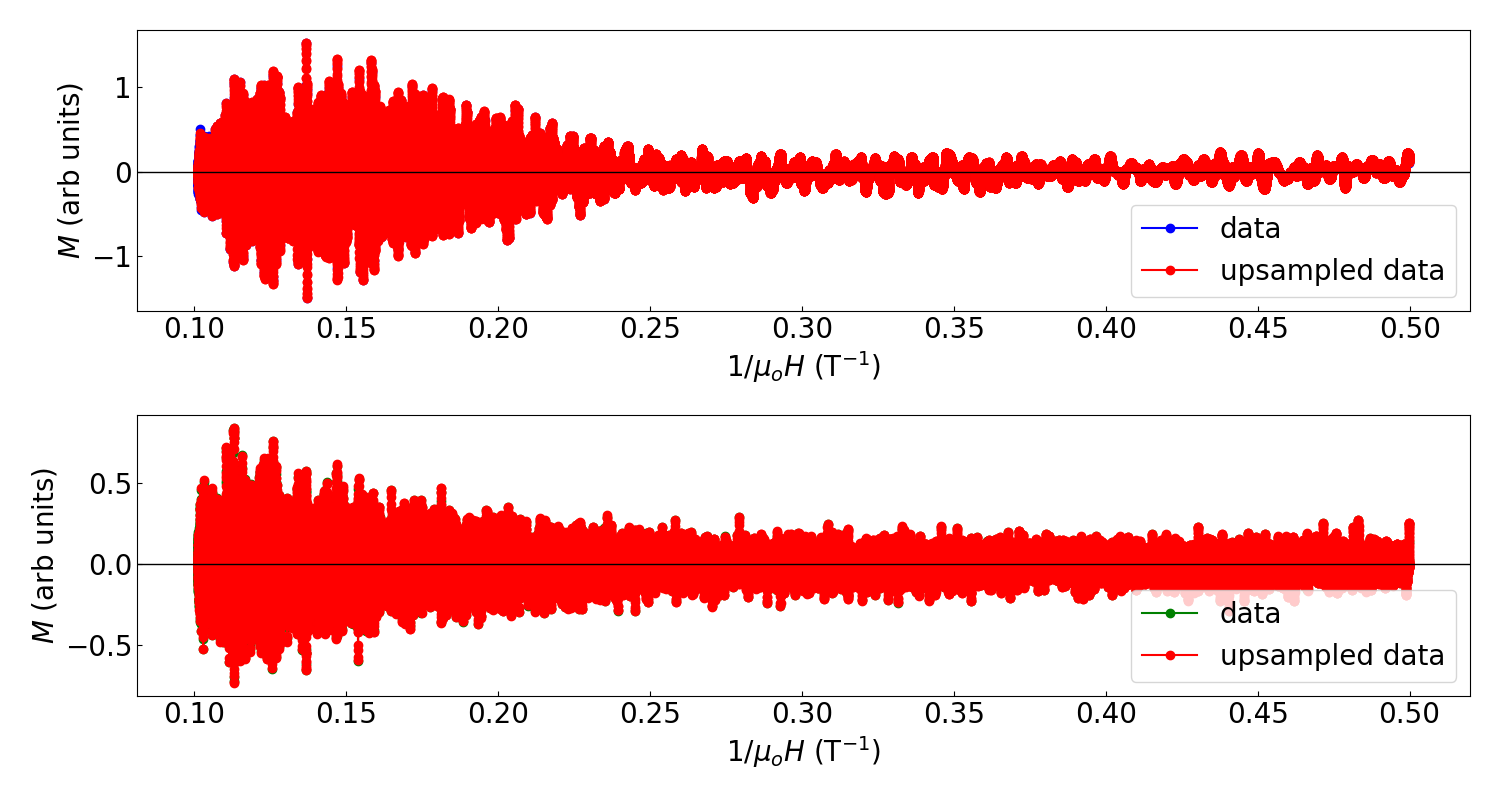

In [9]:
##This section upsamples the data to an evenly spaced inverse field data set

#Upsample factor which will be combined with the (falling field) inverse field spacing
upN = 5

#New dataframe to accommodate new data set length
upsamp_rising = pd.DataFrame()
upsamp_falling = pd.DataFrame()


#Upsampling and evenly spaced data
upsamp_rising['invX'] = np.arange(dat_rising.invX.iloc[0], dat_rising.invX.iloc[-1], abs(dat_rising.invX.iloc[0] - dat_rising.invX.iloc[-1])/(upN * len(dat_falling.invX)))
cs_rising = CubicSpline(dat_rising.invX, dat_rising.norm)
upsamp_rising['fit'] = cs_rising(upsamp_rising.invX)

upsamp_falling['invX'] = np.arange(dat_falling.invX.iloc[0], dat_falling.invX.iloc[-1], abs(dat_falling.invX.iloc[0] - dat_falling.invX.iloc[-1])/(upN * len(dat_falling.invX)))
cs_falling = CubicSpline(dat_falling.invX, dat_falling.norm)
upsamp_falling['fit'] = cs_falling(upsamp_falling.invX)

#plot and compare upsampled data
plt.rcParams.update({'font.size': 20})
fig1, (ax1,ax2) = plt.subplots(2,figsize=(15,8))

ax1.plot(dat_rising.invX, dat_rising.norm, '-ob', label='data')
ax1.plot(upsamp_rising.invX, upsamp_rising.fit, '-or', label='upsampled data')
ax1.set(xlabel=labelXinv, ylabel=labelY)
ax1.tick_params(direction='in')
ax1.legend(loc='lower right')
ax1.axhline(linewidth=1, color='k')

ax2.plot(dat_falling.invX, dat_falling.norm, '-og', label='data')
ax2.plot(upsamp_falling.invX, upsamp_falling.fit, '-or', label='upsampled data')
ax2.set(xlabel=labelXinv, ylabel=labelY)
ax2.tick_params(direction='in')
ax2.legend(loc='lower right')
ax2.axhline(linewidth=1, color='k')

plt.tight_layout()
plt.savefig(tag + 'dat_upsampled' + pic, dpi=300, bbox_inches = "tight")
plt.show()

<IPython.core.display.Javascript object>


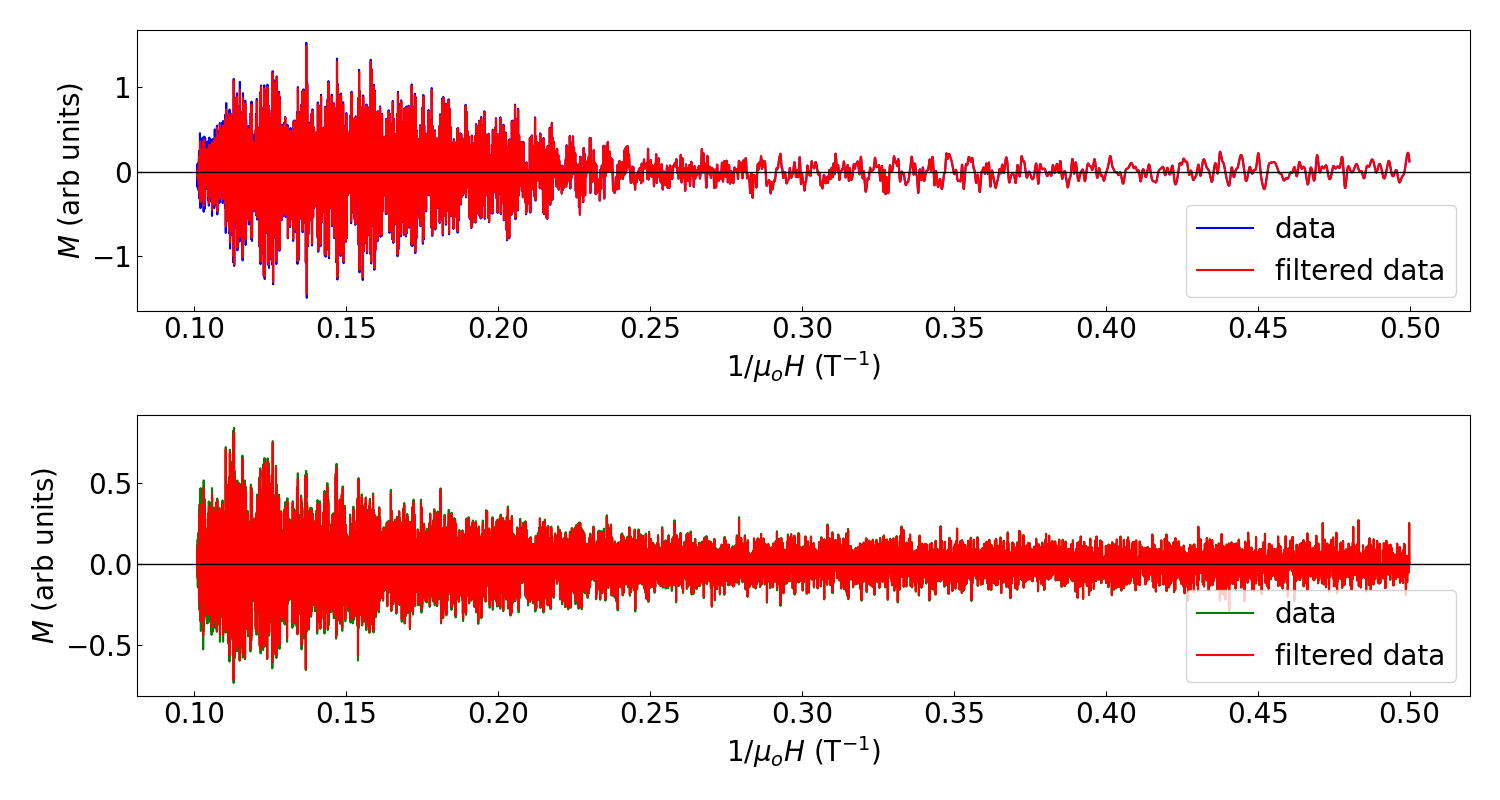

In [10]:
##Smoothing data

######################################################################################################################
#No smoothing

# upsamp_rising['smooth'] = upsamp_rising.fit
# upsamp_falling['smooth'] = upsamp_falling.fit

######################################################################################################################
#Butterworth filter

# #Filter order
# N  = 2    

# #Cutoff frequency
# Wn = 0.5

# b, a = signal.butter(N, Wn, btype='low', output='ba')
 
# upsamp_rising['smooth'] = signal.filtfilt(b, a, upsamp_rising.fit)
# upsamp_falling['smooth'] = signal.filtfilt(b, a, upsamp_falling.fit)
######################################################################################################################
#Rolling window filter

window_rising = 10
window_falling = 5

##window_types##
#boxcar, triang, blackman, hamming, bartlett, parzen, bohman, blackmanharris,
#nuttall, barthann, kaiser (needs parameter: beta), gaussian (needs parameter: std),
#general_gaussian (needs parameters: power, width), slepian (needs parameter: width),
#exponential (needs parameter: tau; center is set to None)

window_type = 'hamming'

upsamp_rising['smooth'] = upsamp_rising.fit.rolling(window_rising, win_type=window_type, center=True).mean()
upsamp_falling['smooth'] = upsamp_falling.fit.rolling(window_falling, win_type=window_type, center=True).mean()

upsamp_rising = upsamp_rising.dropna(axis=0)
upsamp_falling = upsamp_falling.dropna(axis=0)

######################################################################################################################
#plot smoothed data
plt.rcParams.update({'font.size': 20})
fig1, (ax1,ax2) = plt.subplots(2,figsize=(15,8))

ax1.plot(upsamp_rising.invX, upsamp_rising.fit, '-b', label='data')
ax1.plot(upsamp_rising.invX, upsamp_rising.smooth, '-r', label='filtered data')
ax1.set(xlabel=labelXinv, ylabel=labelY)
ax1.tick_params(direction='in')
ax1.legend(loc='lower right')
ax1.axhline(linewidth=1, color='k')

ax2.plot(upsamp_falling.invX, upsamp_falling.fit, '-g', label='data')
ax2.plot(upsamp_falling.invX, upsamp_falling.smooth, '-r', label='filtered data')
ax2.set(xlabel=labelXinv, ylabel=labelY)
ax2.tick_params(direction='in')
ax2.legend(loc='lower right')
ax2.axhline(linewidth=1, color='k')

plt.tight_layout()
plt.savefig(tag + 'dat_smooth' + pic, dpi=300, bbox_inches = "tight")
plt.show()

<a id="FFT-Calculation-and-Plotting"></a><!--Notebook author: Drew Rebar-->

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Importing-Packages">Importing Packages</a></li>
<li><a href="#Import-Data">Import Data</a></li>
<li><a href="#Define-Data-Set-for-Analysis">Define Data Set for Analysis</a></li>
<li><a href="#Edit-and-Split-Data-Set">Edit and Split Data Set</a></li>
<li><a href="#Background Subtraction">Background Subtraction</a></li>
<li><a href="#Data-Preparation-for-FFT">Data Preparation for FFT</a></li>
</ul> 

# FFT Calculation and Plotting

<IPython.core.display.Javascript object>


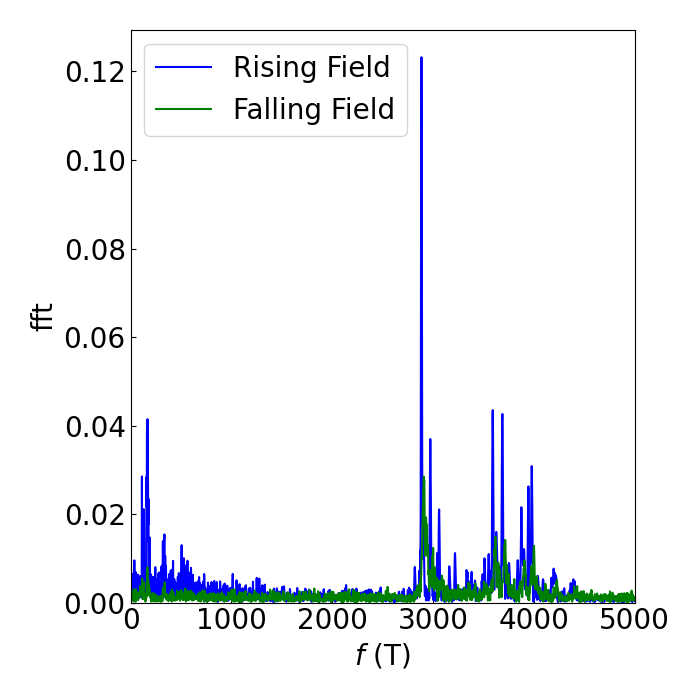

In [11]:
#FFT Calculation
upsamp_rising['fft'] = fft(upsamp_rising.smooth)
upsamp_falling['fft'] = fft(upsamp_falling.smooth)

#Data for fft plotting
step_rising = 0
for n,x in enumerate(upsamp_rising.invX):
    if n == 0:
        x0 = x
    else:
        step_rising += x - x0
        x0 = x
step_rising = step_rising / n
fft_freq_rising = np.linspace(0.0, 1.0 / (2.0 * step_rising), (n + 1) // 2)
fft_rising = 2.0/(n + 1) * abs(upsamp_rising.fft[0:(n + 1)//2])

step_falling = 0
for n,x in enumerate(upsamp_falling.invX):
    if n == 0:
        x0 = x
    else:
        step_falling += x - x0
        x0 = x
step_falling = step_falling / n
fft_freq_falling = np.linspace(0.0, 1.0 / (2.0 * step_falling), (n + 1) // 2)
fft_falling = 2.0/(n + 1) * abs(upsamp_falling.fft[0:(n + 1)//2])

#plot fft
plt.rcParams.update({'font.size': 20})
fig1, (ax1) = plt.subplots(figsize=(7,7))

ax1.plot(fft_freq_rising, fft_rising, '-b', label='Rising Field')
ax1.plot(fft_freq_falling, fft_falling, '-g', label='Falling Field')
ax1.set(xlabel='$f$ (T)', ylabel='fft')
ax1.tick_params(direction='in')
ax1.legend(loc='upper left')

#change plot range here
plt.xlim(0,5000)
plt.ylim(0,)

plt.tight_layout()
plt.savefig(tag + 'fft' + pic, dpi=300, bbox_inches = "tight")
plt.show()